In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

# 데이터 불러오기

In [2]:
bmodeI_data = np.load('/home/jeonk636/MedialImg/Task3/artery3_IData_bmode.npy')
dopplerI_data = np.load('/home/jeonk636/MedialImg/Task3/artery3_IData_doppler.npy')
bmodeQ_data = np.load('/home/jeonk636/MedialImg/Task3/artery3_QData_bmode.npy')
dopplerQ_data = np.load('/home/jeonk636/MedialImg/Task3/artery3_QData_doppler.npy')

In [3]:
print("bI:", bmodeI_data.shape)
print("dI:", dopplerI_data.shape)
print("bQ:", bmodeQ_data.shape,bmodeQ_data.dtype)
print("dQ:", dopplerQ_data.shape,dopplerQ_data.dtype)

bI: (374, 380)
dI: (180, 95, 300)
bQ: (374, 380) float64
dQ: (180, 95, 300) float64


# 복소수

In [4]:
s = dopplerI_data + 1j*dopplerQ_data
print(s.shape)
print(s.dtype)

(180, 95, 300)
complex128


# B_mode

In [5]:
env = np.sqrt(bmodeI_data**2 + bmodeQ_data**2)

In [6]:
log_env = 20 * np.log10(env + 1e-6)

In [ ]:
vmin,vmax = np.percentile(log_env,[5,99])
bmode_new = (np.clip(log_env,vmin,vmax)-vmin)/(vmax-vmin)

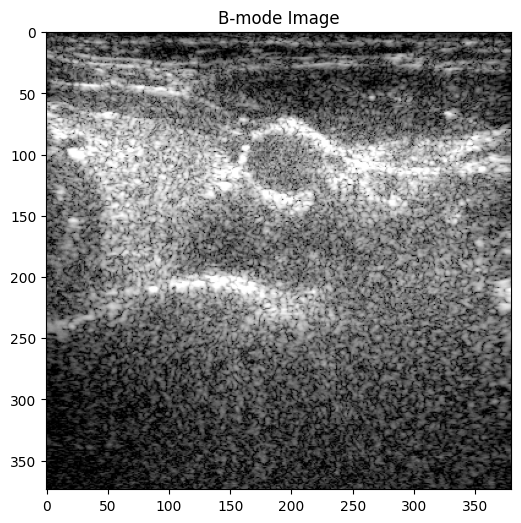

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(bmode_new, cmap='gray', origin='upper')
plt.title('B-mode Image')
plt.show()

# Doppler Power Map

In [9]:
power_before = np.sum(dopplerI_data**2 + dopplerQ_data**2, axis=2)
power_before_norm = (power_before - power_before.min()) / (power_before.ptp())

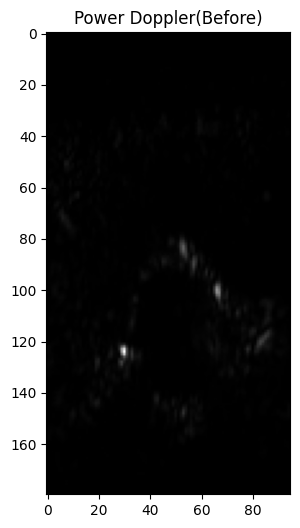

In [10]:
plt.figure(figsize=(6,6))
plt.imshow(power_before_norm, cmap='gray', origin = 'upper')
plt.title('Power Doppler(Before)')
plt.show()

# SVD

In [11]:
d, l, e = s.shape
X = s.reshape(d*l,e)
print(X.shape)

(17100, 300)


# Threshold 결정

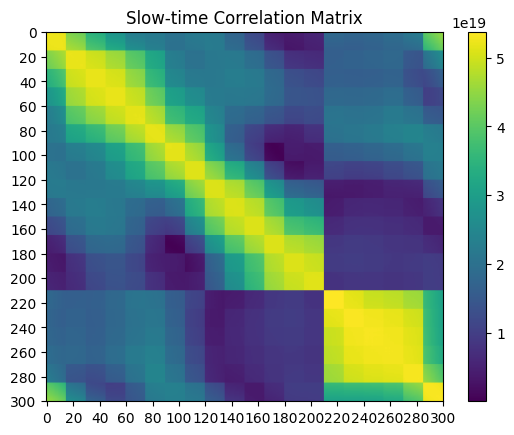

In [12]:
R_t = X.conj().T @ X 
plt.figure()
plt.imshow(np.abs(R_t), aspect='auto', origin='upper')
plt.title('Slow-time Correlation Matrix')
plt.colorbar()
interval = 20
range = np.arange(0, R_t.shape[0]+1, interval)
plt.xticks(range)
plt.yticks(range)

plt.show()

In [13]:
U, S, V = np.linalg.svd(X, full_matrices=False)
print(U.shape, S.shape, V.shape)

(17100, 300) (300,) (300, 300)


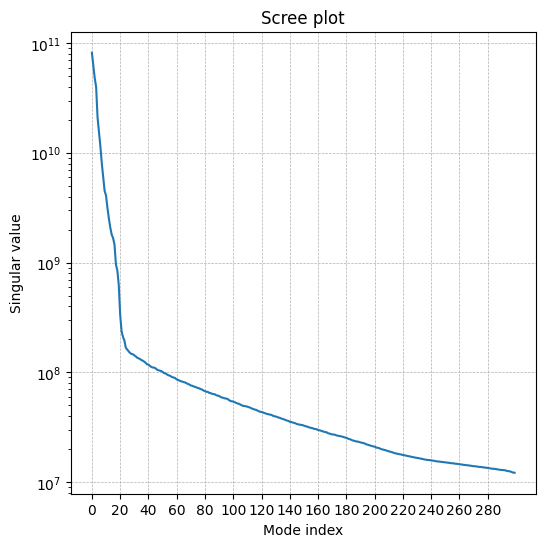

In [14]:
plt.figure(figsize=(6, 6))
plt.plot(S)
plt.yscale('log')
plt.xlabel('Mode index')
plt.ylabel('Singular value')
plt.title('Scree plot')

x_interval = 20
x_ticks = np.arange(0, len(S), x_interval)
plt.xticks(x_ticks)

plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [15]:
S_filt = S.copy()
S_filt[:60] = 0   
S_filt[190:] = 0  
X_new = U @ np.diag(S_filt) @ V
doppler_new = X_new.reshape(d, l, e)
s_new = X_new.reshape(d, l, e)

power_after = np.sum(np.abs(s_new)**2, axis=2)
power_after_norm = (power_after - power_after.min()) / power_after.ptp()

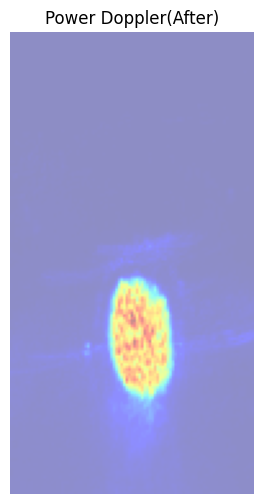

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(power_after_norm, cmap='jet', alpha=0.45, origin='upper')
plt.axis('off')
plt.title('Power Doppler(After)')
plt.show()

In [ ]:
power_resized = cv2.resize(power_after_norm, (l*2, d), interpolation=cv2.INTER_LINEAR)

dx = int(round(190 - 95))
dy = 0
M = np.array([[1, 0, dx], [0, 1, dy]], dtype=np.float32)

aligned = cv2.warpAffine( power_resized, M, (bmode_new.shape[1], bmode_new.shape[0]),
    flags=cv2.INTER_NEAREST,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)
bmode_rgb = np.stack([bmode_new]*3, axis=-1)

cmap = cm.get_cmap('hot')
doppler_rgb = cmap(aligned)[:, :, :3]

overlay = bmode_rgb.copy()
overlay[aligned >= 0.2] = doppler_rgb[aligned >= 0.2] 

/tmp/ipykernel_1808012/4075773299.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hot')


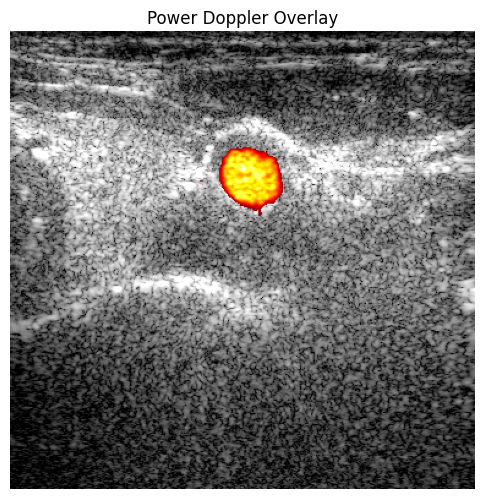

In [18]:
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title('Power Doppler Overlay')
plt.axis('off')
plt.show()

# 컬러 도플러

In [23]:
vessel = power_after_norm > 0.3
phase = np.angle(s_new)  
phase_new = np.unwrap(phase, axis=2)
delta = np.mean(phase_new[:, :, 1:] - phase_new[:, :, :-1], axis=2)

In [ ]:
PRF = 3000
f0 = 7.6*1e6
c = 1540
theta = 0.0
f_d = (delta / (2*np.pi)) * PRF
vel = f_d * c / (2 * f0 * np.cos(theta))

v_max  = PRF * c / (4 * f0 * np.cos(theta))
vel_clipped = np.clip(vel, -v_max, +v_max)
vel_norm  = (vel_clipped + v_max) / (2 * v_max)

In [ ]:
vel_resized = cv2.resize(vel_norm, (l*2, d), interpolation=cv2.INTER_LINEAR)

vel_aligned = cv2.warpAffine(vel_resized, M ,(bmode_new.shape[1], bmode_new.shape[0]),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)

vessel_resized = cv2.resize(vessel.astype(np.uint8), (l*2, d),interpolation=cv2.INTER_NEAREST)

vessel_aligned = cv2.warpAffine(vessel_resized, M, (bmode_new.shape[1], bmode_new.shape[0]),
    flags=cv2.INTER_NEAREST,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
).astype(bool)  

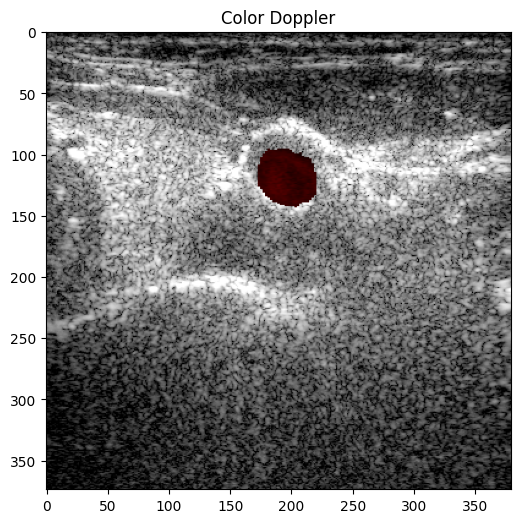

In [ ]:
v_norm = (vel_aligned * 2) - 1 

R = np.clip(v_norm, 0, 1)
G = np.zeros_like(R)
B = np.clip(-v_norm, 0, 1)

vel_rgb = np.stack([R, G, B], axis=-1)

bmode_rgb = np.stack([bmode_new]*3, axis=-1)
overlay = bmode_rgb.copy()
overlay[vessel_aligned] = vel_rgb[vessel_aligned]

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title('Color Doppler')
plt.show()

In [27]:
vel

array([[0.02983776, 0.02861791, 0.0306517 , ..., 0.02847244, 0.02428684,
        0.02239582],
       [0.0267372 , 0.03283747, 0.03423934, ..., 0.02782443, 0.02681123,
        0.02208982],
       [0.02777785, 0.03443787, 0.0117875 , ..., 0.02884468, 0.01825065,
        0.01756656],
       ...,
       [0.03016213, 0.02391568, 0.02369126, ..., 0.02345483, 0.02825942,
        0.02524421],
       [0.03126972, 0.02570018, 0.0295046 , ..., 0.02804395, 0.02607356,
        0.02517905],
       [0.03742077, 0.02742681, 0.02434019, ..., 0.03820587, 0.03510845,
        0.03003106]])